### Link to git repository:
https://github.com/Aaresh1705/CSS_project_final

### Link to website:
https://aaresh1705.github.io/CSS_project_final/

### Contributions:
| Name               | Motivation | Network stats | Indpeth network analysis | Discussion | Website |
|--------------------|------------|---------------|--------------------------|------------|---------|
| Mikkel (s234860)   | 0%         | 0%            | 0%                       | 0%         | 0%      |
| Kantinka (s235058) | 0%         | 0%            | 0%                       | 0%         | 0%      |
| Marcus (s234816)   | 0%         | 0%            | 0%                       | 0%         | 0%      |

# Final Project
### Musician community analysis in Denmark

In [3]:
# Library imports
# Native libraries
import re
import ast
from itertools import chain
from collections import Counter
from itertools import combinations
import pickle
from collections import defaultdict

# Third party libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as Patch
import networkx as nx
import requests
from bs4 import BeautifulSoup
#import discogs_client

In [ ]:
# Self-made function imports
from functions.loading_articles import get_music_articles, get_article_content_by_id
from functions.member_fetch_functions import members_to_df,webscrape_members
from functions.plotting_networks import plot_2graphs, scatter_dist
from functions.genre_function import get_genre_from_page_id
from functions.get_genre import get_genre

## Motivation

<span style="color:green"> Motivation
- [ ] <span style="color:green"> What is your dataset?
- [ ] <span style="color:green"> Why did you choose this/these particular dataset(s)?
- [ ] <span style="color:green"> What was your goal for the end user's experience?

We have decided to look into the local musician communities in Denmark where we will look into the amount of overlap there is of musicians across bands.
Our dataset consists of as many musicians and bands within Denmark's local music scene as we could find, both active and inactive. This is represented as two interlinked sub sets (1) individual artists and (2) the bands they play in. In order to construct the dataset, we [INSERT METHODS HERE], then cleaned and merged them into a bipartite table of musician $\leftrightarrow$ band memberships.

We chose this dataset to analyse a dual-layer network where one layer connects musicians who share band members, and the other connects bands that share musicians. This makes it possible to explore who collaborates with whom and how groups are interconnected through shared personnel. In additon focusing on a geographical bounded community (Denmark) keeps the scope of the project manageable.

Our goal for the end user experience is to deliver an interactive exploration tool that helps music promoters, venue programmers, and the musicians themselves to:
* Visualize collaboration clusters! Quickly spot creative comminuties and understand how they overlap.
* Identify bridges and inluencers! Discover artists or bands that serve as connectors between scenes or genres.
* Inform collaboration decisions! Use network insights to plan events, open up for possible collaborations, or target promotional direction.

<span style="color:red">
$\downarrow$ DEPRICATED $\downarrow$

We will be looking into two overlapping networks, one where musicians connect to musicians and another with groups connect to other groups. This will be done by constructing a bipartite group-member network where musicians linked by common groups and groups linked by common musicians.

By analysing who plays with whom, and how bands share members, we can get a view into how creative communities form, and spread influence across the music scene. This kind of insight could matter for music promoters, venue owners, and the musicians themselves.

## Fetching the data set

The first part of collecting our dataset was getting a list of all Danish Music Groups. We chose to do this through Wikipedia as most groups have a Wikipedia page. The advantage of doing this compared to other methods, like taking bands from spotify, is ensuring that we only get groups of enough importance that they have their own Wiki-page.

We collected a list of all wikipedia categories of different Danish music groups.

NOTE: This section might appear a bit messy. This is due to the fact that the data is fetched over a long time period and by different members of our group.

"""This project investigates the network of Danish music groups, defined by their shared members. All danish music groups are collected from the danish Wikipedia though running though all wiki categories of danish groups. The members of the groups are collected from Wikipedia if possible and the music website Discogs otherwise. From this data a network is created, edges of the network being a musician being a part of a music group. This means that musicians only connect to groups and vice versa. This creates a bipartite network as shown in the figure below (number of nodes not to scale, for better visualisation). For the analysis, we have focused on the projections of the network, onto musicians and groups respectively. This results in a network where groups are connected if they have at least 1 shared member, and musicians are connected if they have been in the same group."""

In [ ]:
with open("categories/categories_groups.txt", "r") as file:
    categories_groups = file.read().splitlines()

# we use a selfmade function to do the wiki API call
music_groups = get_music_articles(categories_groups)

In [ ]:
# setting initial dataframe
df_groups = pd.DataFrame(music_groups)
df_groups = df_groups.drop(columns=["ns"])

# df_groups.to_csv("data/music_groups.csv", index=False)

In [ ]:
# Fetching members using wiki API
df_groups["member"] = df_groups["title"].apply(members_to_df)

In [ ]:
# Using webscraping for members that can't be fetched through wiki API
empty_member_indices = df_groups[df_groups["member"].apply(lambda x: x == [])].index
df_groups.loc[empty_member_indices, "member"] = df_groups.loc[empty_member_indices, "title"].apply(webscrape_members)

Cleaning the data

In [ ]:
def remove_parentheses(name):
    return re.sub(r'\s*\(.*?\)', '', name).strip()

df_groups["cleaned_member"] = df_groups["member"].apply(
    lambda members: [remove_parentheses(member) for member in members])

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member.split(" - ")[0].strip() for member in members 
                     if member and member[0].isupper() or member[:2] == ""])

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member for member in members 
                     if member and member[-1].isalpha() or member[-2:] == ""])

def remove_quotes(name):
    return name.replace('"', '').replace("'", '').strip()

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [remove_quotes(member) for member in members])

musical_instruments = [
    'Sang', 'Sanger', 'Vokal', 'Guitar', 'El-guitar', 'Piano', 'Keys', 'Klaver', 'Drums', 'Trommer', 'Bas', 'Bass', 'Violin', 'Saxophone', 'Saxofon' 'Trumpet',
    'Flute', 'Fløjte', 'Cello', 'Clarinet', 'Harpe', 'Trombone', 'Synthesizer', 'Keyboard', 'Sang/Guitar'
]

df_groups["cleaned_member"] = df_groups["cleaned_member"].apply(
    lambda members: [member for member in members if member not in musical_instruments])

We discovered that we were still missing large number of members and chose to use the discogs API to fetch the members of the remaining data.

### Discogs

We wrote a function to get members from Discogs, using Discogs API. To make these request, an authorization token was needed. These are seen below.

The documentation for the DIscogs API can be found following this link:
https://www.discogs.com/developers?gad_source=1&gad_campaignid=22323983934&gclid=Cj0KCQjwxJvBBhDuARIsAGUgNfg8YP5mi2SXeOJzpzrPtn_EcHbe82h6ArgZHsdf1Pl0edRPb6eqREMaAok5EALw_wcB 

In [19]:
import discogs_client
consumer_key = 'ykUodTXeeVzqTJkACRzX'
consumer_secret = 'fOWGGoeHRESxkDPVoPFQKJBaTtDrFFRn'
d = discogs_client.Client('CSS_memberfetch/1.0', consumer_key=consumer_key, consumer_secret=consumer_secret)
# Generate the authorize URL
request_token, request_token_secret, authorize_url = d.get_authorize_url()
authorize_url

'https://www.discogs.com/oauth/authorize?oauth_token=gjOWvhrlafvYpLOzJCRCGptQjViCWumeQfHMeBIC'

In [21]:
# After authorization, Discogs will give you a verifier code
verifier = 'aLBKZFPFpg'
# Get the access token
access_token, access_token_secret = d.get_access_token(verifier)
d.set_token(access_token, access_token_secret)

In [22]:
def get_discogs_members(band_name):
    
    if band_name[-7:]==" (band)": # to avoid (band) ending for messing up search results
        band_name = band_name[:-7]
    
    results = d.search(band_name, type='artist') 
    if len(results)>0:
        i = 0
        while i < len(results):
            artist = results[i]
            if artist.name.lower() in band_name.lower():
                break
            i += 1
        
        if i != len(results):
            try:
                if hasattr(artist, 'members'):
                    return [member.name for member in artist.members]
            except discogs_client.exceptions.HTTPError as e:
                pass
    return []

Initially we only fetched members from Discogs for the groups who didn't have any members from the Wikipedia webscraping. We later realized that for around a 100 groups, Wikipedia only provided 1 member, even though Discogs had multiple. For this reason we chose to also fetch members for the groups who had only 1 member.

In [ ]:
#loading the groups
df_groups = pd.read_csv("data/groups_wMembers.csv")
#getting the groups with no members
empty_member_indices = df_groups[df_groups["cleaned_member"].apply(lambda x: x == "[]")].index
#fetching members from discogs
df_groups.loc[empty_member_indices, 'cleaned_member'] = df_groups.loc[empty_member_indices, 'title'].apply(get_discogs_members)
#saving the updated members to csv
# df_groups.to_csv("data/groups_wMembers2.csv", index=False)

In [ ]:
#loading the groups again
df_discgroups = pd.read_csv("data/groups_wMembers2.csv")
df_discgroups["disc_members"] = [[] for _ in range(len(df_discgroups))]
df_discgroups

# getting indexs of relevant rows
missing_members = df_discgroups[df_discgroups["cleaned_member"].apply(lambda x: len(ast.literal_eval(x))<=1)].index
wiki_indices = df_groups[df_groups["cleaned_member"].apply(lambda x: x != "[]")].index
members_to_check = [i for i in missing_members if i in wiki_indices]

#fetching from discogs
df_discgroups.loc[members_to_check, 'disc_members'] = df_discgroups.loc[members_to_check, 'title'].apply(get_discogs_members)

# merging with the original members
df_discgroups.loc[members_to_check, 'disc_members'] = df_discgroups.loc[members_to_check, 'title'].apply(get_discogs_members)
df_discgroups["all_members"] = df_discgroups["all_members"].apply(lambda memberlist: [str(member) for member in memberlist])

#saving the updated members to csv
#df_discgroups.to_csv("data/groups_wMembers3.csv", index=False)

In [41]:
df_discgroups = pd.read_csv("data/groups_wMembers3.csv")
print(f"{sum(df_discgroups['all_members'] == '[]')} groups without members")
print(f"{sum(df_discgroups['all_members'] != '[]')} groups with members")

166 groups without members
868 groups with members


After the fetch of members from Discogs we had found the members of 868 of the groups and had 166 groups with no found members. Using more methods we might would have been able to obtain more members. We decided to move on at that point though, for the scope of this project. We expect that the groups who didn't have members listed on either Wikipedia nor Discogs, also might be the smallest, most unknown groups, and thus not of great importance to the danish music scene.

### Fetching text and genres for the groups
1. We fetched the intro text from the wikipedia articles

2. We searched through the intro texts for genres.


    Genres were found by hardcoded approach. With different spellings, we searched the intro texts of the wikipedia articles.

3. We used API calls and webscraping to fetch additional genres.
    
    
    Wiki API, MusicBrainz and webscraping was used.

4. We combined the genres found.

In [ ]:
# Step 1
df_groups["intro_text"] = df_groups["pageid"].apply(get_article_content_by_id)

In [ ]:
# Step 2
df_groups["genres"] = df_groups["intro_text"].apply(get_genre)

In [ ]:
# Step 3
df_api_genre = df_groups.copy()
df_api_genre["genre"] = df_groups["pageid"].apply(get_genre_from_page_id)

In [ ]:
# Step 4
empty_genre_idx = df_groups[df_groups['genres'].isna() | (df_groups['genres'] == '' ) | (df_groups["genres"] == "[]")].index

for idx in empty_genre_idx:
    api_genre = df_api_genre.at[idx, 'genre']

    if pd.notna(api_genre) and api_genre != "Genre not found.":
        translated_genre = get_genre(api_genre)
        df_groups.at[idx, 'genres'] = translated_genre

In [ ]:
# Missing genres before and after step 4
print(len(empty_genre_idx))
print(len(df_groups[df_groups['genres'].isna() | (df_groups['genres'] == '' ) | (df_groups["genres"] == "[]")]))

## Network stats

<span style="color:green"> Basic stats. Let's understand the dataset better

- [ ] <span style="color:green"> Write about your choices in data cleaning and preprocessing
- [ ] <span style="color:green"> Write a short section that discusses the dataset stats (here you can recycle the work you did for Project Assignment A)


### Bipartite network

We begin by setting up the network. We have chosen to first create a bipartite network, creating edges between a musician and a group if the musician is a member of the group. This means that since we create the network from edges, groups with no found members will automatically be removed from the dataset, as they dont have any edges.

In [4]:
#Making edgelist
df_groups = pd.read_csv("data/groups_wMembers3.csv")
df_groups["edgelist"] = df_groups.apply(lambda row: [(row["title"], member) for member in ast.literal_eval(row["all_members"])], axis=1)
edgelist = [edge for sublist in df_groups["edgelist"] for edge in sublist]

#creating networkX graph
B = nx.Graph()
B.add_edges_from(edgelist)

#basic stats
print(f"N = {len(B.nodes)},", f"Edges = {len(B.edges)}")
print(f"Number of connected components: {len((list(nx.connected_components(B))))}")

N = 4931, Edges = 4645
Number of connected components: 480


In [5]:
all_groups = list([group for group in df_groups["title"].values if group in B.nodes])
all_musicians = list(np.unique([
    str(member)
    for row_list in df_groups["all_members"].values
    for member in ast.literal_eval(row_list)
    if member in B.nodes and member != ''
]))
all_musicians = [str(member) for member in all_musicians]

# Compute centrality for each partition
musician_centrality = nx.algorithms.bipartite.degree_centrality(B, all_musicians)
group_centrality = nx.algorithms.bipartite.degree_centrality(B, all_groups)

# Calculate the average degree
musician_centrality_average = np.mean(list(musician_centrality.values()))
musician_average_degree = musician_centrality_average * len(all_groups)

group_centrality_average = np.mean(list(group_centrality.values()))
group_average_degree = group_centrality_average * len(all_musicians)

print(f"Average degree of musicians: {musician_average_degree}")
print(f"Average degree of groups: {group_average_degree}")

Average degree of musicians: 1.2316993650967274
Average degree of groups: 5.8362556138177775


In [6]:
groups_degree = [degree for node, degree in dict(B.degree).items() if node in all_groups]
musician_degree = [degree for node, degree in dict(B.degree).items() if node in all_musicians]
group_average_degree = sum(groups_degree)/len(groups_degree)
musician_average_degree = sum(musician_degree)/len(musician_degree)

print(f"Average degree of musicians: {musician_average_degree}")
print(f"Average degree of groups: {group_average_degree}")

Average degree of musicians: 1.1227646205896569
Average degree of groups: 5.840452261306533


So, on average a musician is a part of 1.23 music groups and on average a music group has 5.84 members.

### Projections networks

We can project our bipartite network in two ways: The musicians as nodes connected by common music groups and vice versa.

In our continued network analysis, we will mainly focus on the Danish Music Groups (DMG) network to narrow the scope and enable a more in-depth exploration. The musicians network has an interpretation problem as nodes with a high degree are hard to interpret. High-degree musicians can both be associated with multiple music groups or just be a musician of a very large music group (ex: a symphony orchestra). This is also an influence in the DMG projection, however, here a group also has to share musicians with other groups to create an edge and thereby the large music groups do not automatically create many edges. Lastly, very few musicians (of famous bands even) don’t have a wikipedia article, although fairly unknown bands have. Thereby it is natural to focus on music groups, which also will be the focus of our text analysis.

In [7]:
# creating projections networks

# DMG network:
G = nx.projected_graph(B, all_groups, multigraph=False)

# Danish musicians network
M = nx.projected_graph(B, all_musicians, multigraph=False)

We calculate the probability (p) average degree (k) of the Musicians network 
ref[Section 3.2, equation (3.2) in Network Science, Albert-Laszlo Barabasi]

In [8]:
def basic_graph_stats(G):
    N = G.number_of_nodes()
    L = G.number_of_edges()

    p = L / ((N*(N-1))/2)  # for undirected graphs, we divide by 2

    k = p*(G.number_of_nodes() - 1)

    print(f"Size of network: {N}")
    print(f"Probability p: {p}")
    print(f"Average degree: {k}")
    return N,p

print("MUSICIANS NETWORK")
N_musicians,p_musicians = basic_graph_stats(M)
print("")
print("DMG NETWORK:")
N,p = basic_graph_stats(G)

MUSICIANS NETWORK
Size of network: 4151
Probability p: 0.004870476848371563
Average degree: 20.212478920741987

DMG NETWORK:
Size of network: 814
Probability p: 0.0016772895001677288
Average degree: 1.3636363636363635


#### Degree distribution and plotting
We will now plot our two projection networks compared to random networks generated with the same size (N) properbility (p) of two nodes having a link.

In [ ]:
def random_network(N,p):
    
    #Start with N isolated nodes.
    R = nx.Graph()
    R.add_nodes_from(range(N))

    #Select a node pair and generate a random number between 0 and 1
    for u in range(N):
        for v in range(u+1,N):
            if np.random.rand() < p: #If the number exceeds p:
                R.add_edge(u,v) #connect the selected node pair with a link, otherwise leave them disconnected.
    return R

F = random_network(N,p)
F_musicians = random_network(N_musicians,p_musicians)

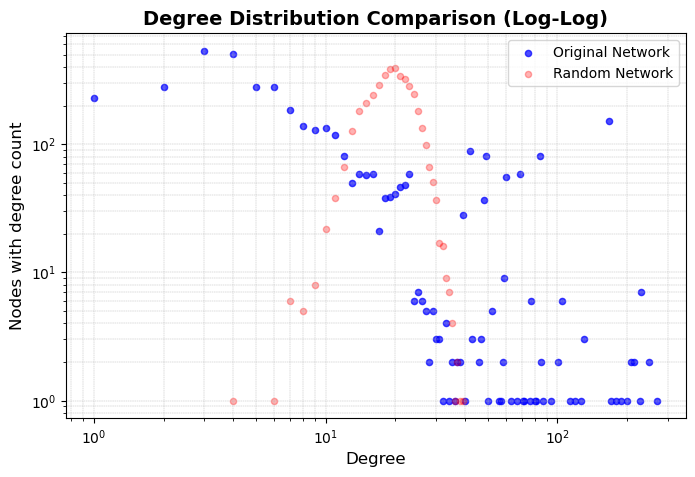

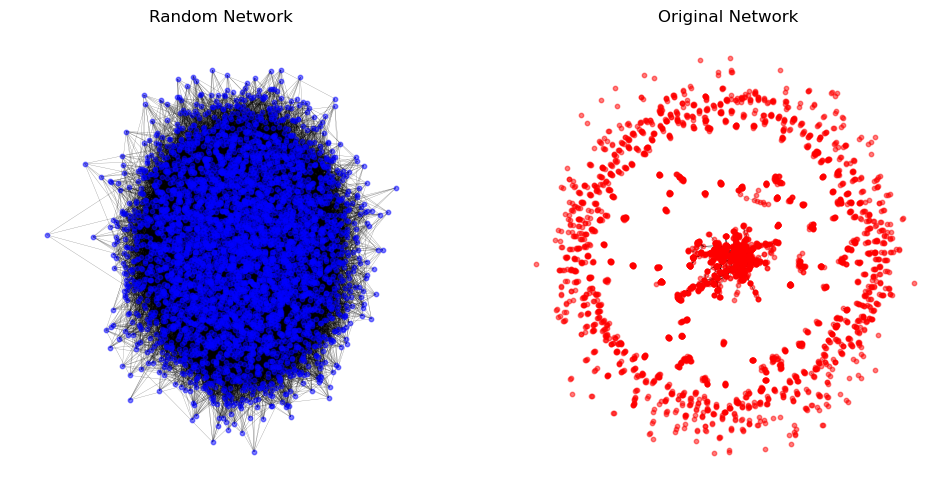

In [ ]:
#plots for the Danish Musicians network:
scatter_dist(M, F_musicians)
plot_2graphs(M, F_musicians)

We see a big diffence between the random and Musicians network. The random network is fully connected and in the super-critical regime as k = 20 >> 1. In contrast, the musicians network is disconected, this makes sense because many musicians are solo artist.

___

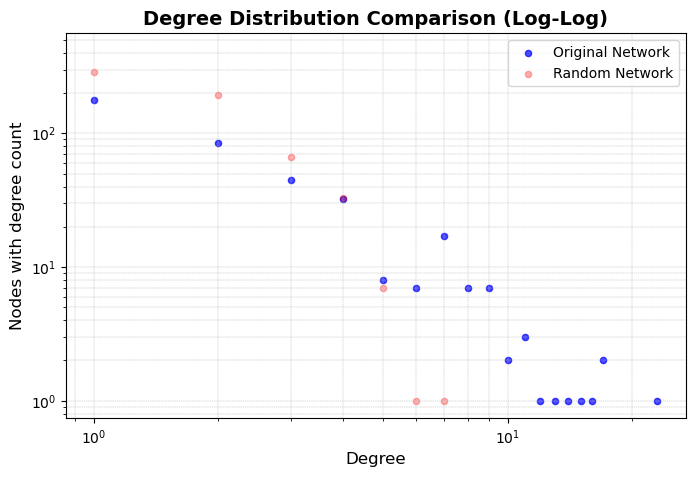

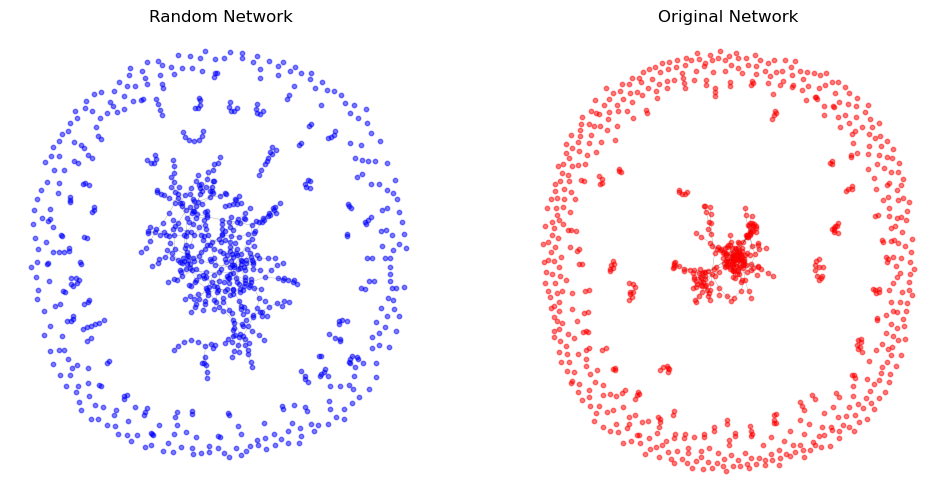

In [ ]:
#plots for the DMG network:
scatter_dist(G, F)
plot_2graphs(G, F)

In the network plot, we see a diffence between the networks. The random network is not fully connected but is in the supercritical regime as k = 1.36 > 1. The DMG network has more disconected nodes and more connected center which corresponds to the scatter plot. It seems resonable that it has more disconnected nodes as it is natural that bands never break up and share musicians with other music groups. To investigate the very connected center, we will try to look only at the giant component.

The degree destribution scatter plot suggests that our network follows a heavy tail distribution, as it in a log-log plot nearly follows the diagonal in contrast to the random network. Also, potential hub nodes emerges in the right corner of the plot.

In [ ]:
hubnodes = sorted(G.degree, key=lambda x: x[1], reverse=True)[:5]
hubnodes

[('Kansas City Stompers', 23),
 ('Frede Fup', 17),
 ('Lone Kellermann og Rockbandet', 17),
 ('Delta Cross Band', 16),
 ('Gorilla Angreb', 15)]

To get a better picture we investigate the centrality:

In [9]:
# Centrality:
eigen_centrality_G = nx.eigenvector_centrality(G)

top_10_G = sorted(eigen_centrality_G.items(), key=lambda x: x[1], reverse=True)[:10]
print("Top 10 nodes by Eigen centrality in the DMG network:")
print("")
for node, centrality in top_10_G:
    print(f"{node} - Centrality: {centrality:.4f}")

Top 10 nodes by Eigen centrality in the DMG network:

Lone Kellermann og Rockbandet - Centrality: 0.3162
Kansas City Stompers - Centrality: 0.3152
Frede Fup - Centrality: 0.3108
Kim Larsen & Bellami - Centrality: 0.2907
Delta Cross Band - Centrality: 0.2784
Starfuckers - Centrality: 0.2643
På Slaget 12 - Centrality: 0.2056
Skousen & Ingemann - Centrality: 0.2055
Røde Mor - Centrality: 0.1972
Culpeper's Orchard - Centrality: 0.1899


In [12]:
hub_n_central = df_groups[(df_groups["title"] == "Kansas City Stompers") | 
               (df_groups["title"] == "Lone Kellermann og Rockbandet")]

# Most central and largest hub node
list(hub_n_central["cleaned_member"].values)

["['Lone Kellermann', 'Bjørn Uglebjerg', 'Joachim Ussing', 'Ivan Horn', 'Thomas Grue', 'Nils Henriksen', 'Wili Jønsson', 'Billy Cross']",
 "['Niels Abild', 'Åke Gram', 'Alex Riel', 'Bent Clausen', 'Bo Stief', 'Finn Ziegler', 'Gert Rostock Jensen', 'Gunhild Carling', 'Hans Åsberg', 'Hans Fagt', 'Hans Verner Ottesen', 'Hugo Rasmussen', 'Jacob Andersen', 'Jan Glæsel', 'Jan Hem', 'Jens Haack', 'Jens Melgaard', 'Jesper Lundgaard', 'John Kaas Ibsen', 'Johnny Goffy Rasmussen', 'Karsten Kristensen', 'Kenneth Agerholm', 'Kurt Riedel', 'Lennart Flindt', 'Lennart Gruvstedt', 'Niels Bødker', 'Niels Olsen', 'Niels Ratzer', 'Niels Stuart', 'Nils Henriksen', 'Nils Rehman', 'Nynne Lange', 'Ole Berg', 'Ole Hansen', 'Ole Kock Hansen', 'Ole Ousen', 'Ole Skipper Mosgaard', 'Palle Bremer Nielsen', 'Peder Kragerup', 'Pelle Thomsen', 'Per Carsten Petersen', 'Søren Fechtenberg', 'Steen Hansen', 'Svend Baaring', 'Svend-Erik Nørregaard', 'Torben Hertz', 'Torben Munk', 'Ulf Johansson Werre', 'Verner Work Nielsen

The "Kansas City Stompers" is much larger band than the "Lone Kellermann og Rockbandet". However, the last mentioned has a higher centrality.
___

## Indepth network analysis
From now on the focus will only be on the DMG network.

First we will investigate the giant.

<span style="color:green"> Tools, theory and analysis. Describe the process of theory to insight

- [ ] <span style="color:green"> Talk about how you've worked with text, including regular expressions, unicode, etc.
- [ ] <span style="color:green"> Describe which network science tools and data analysis strategies you've used, how those network science measures work, and why the tools you've chosen are right for the problem you're solving.
- [ ] <span style="color:green"> How did you use the tools to understand your dataset?


In [ ]:
G_components = nx.connected_components(G)
G_largest_component = max(G_components, key=len)
G_giant = G.subgraph(G_largest_component)


F_components = nx.connected_components(F)
F_largest_component = max(F_components, key=len)
F_giant = F.subgraph(F_largest_component)

G_giantN = G_giant.number_of_nodes()
G_giantp = G_giant.number_of_edges() / ((G_giantN*(G_giantN-1))/2)

F_giantN = F_giant.number_of_nodes()
F_giantp = F_giant.number_of_edges() / ((F_giantN*(F_giantN-1))/2)

print(f"Size of giants (DMG,RN): {G_giantN, F_giantN}")
print(f"Average degrees (DMG,RN): {G_giantp*(G_giantN - 1), F_giantp*(F_giantN - 1)}")

Size of giants (DMG,RN): (202, 403)
Average degrees (DMG,RN): (4.0, 2.064516129032258)


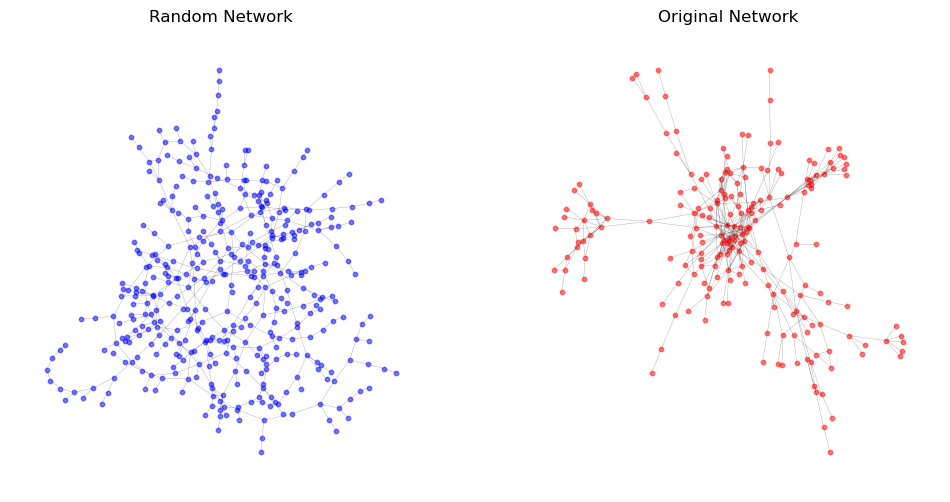

In [ ]:
plot_2graphs(G_giant, F_giant)

Looking at the plot, the DMG network does not appear random. This encourage us to investigate the possibility of communities and the small-world property.

### Small-world property

We will in this section look at the giant component, which somewhat corresponds to the largest community of connected

In [ ]:
# Calculate the average shortest path length within the giant:
shortest_G = nx.average_shortest_path_length(G_giant,None)
shortest_F = nx.average_shortest_path_length(F_giant,None)

print(f"Average shortest path length for the giant in RN: {shortest_F}")
print(f"Average shortest path lenght for the giant in DMG: {shortest_G}")

In [ ]:
clustering_G = nx.average_clustering(G_giant)
clustering_F = nx.average_clustering(F_giant)

print(f"Clustering coefficient for the giant in RN: {clustering_F}")
print(f"Clustering coefficient for the giant in DMG: {clustering_G}")

The DMG giant has an average shortest path of 5.5, which means that, on average, there is a maximum of around six links between two music groups. This is more than half the average shortest path in the random network. This is an atypical result ($L_{real}$ > $L_{random}$) and might be due to few highly musician sharing groups - hub nodes (one potential hub nodes discovered below the scatter plot). However this might not exclude that the network may still have small-world properties. The clustering coefficients indicate significantly higher clustering than the random network, which is a key characteristic of small-world networks. All togehter, this suggests that the DMG network, may possess small-world characteristics.

It is a very interesting insight. The bands in the giant tend to cluster strongly and might have hub tendencies. To follow up, we will now try to understand the character of the clusters in network.

### Assortativity

In [ ]:
assortativity_G = nx.degree_assortativity_coefficient(G)
assortativity_F = nx.degree_assortativity_coefficient(F)

print(f"Assortativity coefficient for RN: {assortativity_F}")
print(f"Assortativity coefficient for the DMG network: {assortativity_G}")

So, the DMG network has a high assortiativity, which suggest that high-degree music groups are more likely to connect to other high-degree groups. This may suggest genre-based clustering.

Genres were found by hardcoded approach. With different spellings, we searched the intro texts of the wikipedia articles.

To examine the categorical assortativity using genre, we have to take into account that groups have assigned multiple non-sorted genres. This means we might have to use similarities of the genres between two music groups to get a satisfactorily interpretable result. For this we use jaccard similarity. However, this is now formally not a assortativity measure as a jaccard similarity ranges from 0 to 1. Thereby the average jaccard between linked nodes will also have the same range. So:

Average similarity = 0: All connected music groups has different genres.\
Average similarity = 1: All connected music groups has the same set of genres.

In [ ]:
df_groups = pd.read_csv("data/groups_wMembers_Text_Genres.csv")

genres_dict = dict(zip(df_groups["title"], df_groups["genres"]))

nx.set_node_attributes(G, genres_dict, name="genre")

In [ ]:
def g2set(g1_raw):
    # Convert string to actual list if needed
    if isinstance(g1_raw, str):
        try:
            g1 = ast.literal_eval(g1_raw)
        except (ValueError, SyntaxError):
            g1 = []
    else:
        g1 = g1_raw  # Already a list

    return set(map(str.strip, g1))

def genre_overlap(g1, g2):
    set1 = g2set(g1)
    set2 = g2set(g2)
    return len(set1 & set2) / len(set1 | set2) if len(set1 | set2) else 0 # Jaccard similarity

# Average genre similarity across all edges
total = 0
count = 0
for u, v in G.edges():
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")
    if genre_u and genre_v:
        sim = genre_overlap(genre_u, genre_v)
        total += sim
        count += 1

avg_similarity = total / count if count else 0
print(f"Average genre similarity between connected groups: {avg_similarity}")

In [ ]:
# for comparison, we can also calculate the average genre similarity for all nodes:
total_sim = 0
count = 0

for u, v in combinations(G.nodes(), 2):  # All unique pairs
    genre_u = G.nodes[u].get("genre")
    genre_v = G.nodes[v].get("genre")

    if genre_u and genre_v:
        sim =  genre_overlap(genre_u, genre_v)
        total_sim += sim
        count += 1

avg_global_jaccard = total_sim / count if count else 0
print(f"Average global Jaccard similarity (all node pairs): {avg_global_jaccard}")

In [ ]:
groupsG = G.copy()
groupsG.remove_nodes_from(list(nx.isolates(groupsG)))


def plotNetwork_color(G):
    #Genre hierarchy
    hierarchy = ["eurovision pop", "jazz", "choral", "classical", "heavy metal", "country", "electronic", "folk" , "pop", "rock"]
    # the hierarchy is defined in a way that the most common genres pop and rock are at the end of the list

    def pick_genre(genres_raw):
        if isinstance(genres_raw, str):
            try:
                genres = ast.literal_eval(genres_raw)
            except (ValueError, SyntaxError):
                genres = []
        else:
            genres = genres_raw or []

        genres_lower = [g.lower().strip() for g in genres]

        for genre in hierarchy:
            if genre in genres_lower:
                return genre
        return "other"


    genre_map = {node: pick_genre(G.nodes[node].get("genre")) for node in G.nodes()}


    unique_genres = sorted(set(genre_map.values()))

    color_map = {genre: plt.cm.tab10(i % 10) for i, genre in enumerate(unique_genres)}

    #NOTE: is the right genre swapped??
    color_map["other"], color_map["jazz"] = color_map["jazz"], color_map["other"]

    node_colors = [color_map[genre_map[node]] for node in G.nodes()]


    # Plot the graph
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 9))

    nx.draw(
        G,
        pos,
        node_color=node_colors,
        with_labels=False,
        node_size=50,
        edge_color='gray'
    )

    # Create a legend as a table
    legend_elements = [Patch(facecolor=color_map[genre], label=genre) for genre in unique_genres]
    plt.legend(handles=legend_elements, title="Genre (Color)", loc="upper right", bbox_to_anchor=(1.15, 1.0))

    plt.title("Network Colored by Representative Genre")
    plt.tight_layout()
    plt.show()

plotNetwork_color(groupsG)
plotNetwork_color(G_giant)

From the similarity average and global similarity average we se a significantly higher similarity between connected nodes. So, music groups more often link with music groups with similar sets of genres. This indicates that communities tend to share the same genres, which makes sense as a rock musician might no be able to play in a classical orcestra also. Looking at the colored plot of the giant of the DMG network, we see an isolated cluster in the buttom consisting mostly of the genres "classical" and "choral", which are rather similar genres. In the very connected middle the genres "rock", "pop" and "jazz" seem to be dominant.

### Community detection

In the following section, we will study the communities that appears in the network, and apply text analysis to understand what connects music groups.

In [57]:
with open("data/groups_graph.pkl", "rb") as f:
    GroupsG = pickle.load(f)

Since isolated groups will never be part of a community we remove them from the network

In [58]:
GroupsG.remove_nodes_from(list(nx.isolates(GroupsG)))
len(GroupsG.nodes)

398

We tried two different methods of partitioning the group network. Firstly a division based on biconnected components, meaning that if only 1 group is making the network connected, the network is split up into different communities at that group (partition 1). Secondly we used the Louvain community detection algorithm (partition 2).

Below partition 1 is created, using the networkX function binconnected components to compute all biconnected components. For analysis of communities, each node will have to be assigned uniquely to a community. This is not the case for bicomponents. We therefore, if a node belonged to multiple commnities, assigned it to the biggest community, as the bigger clusters are more meaningful to the overall structure of the network.

In [64]:
#Get all biconnected components as sets of nodes
bicomponents = list(nx.biconnected_components(GroupsG))

#Sort components by decreasing size
bicomponents.sort(key=lambda c: len(c), reverse=True)

#Assign nodes uniquely to clusters
partition1 = {}
assigned_nodes = set()
cluster_id = 1
for component in bicomponents:
    # Get only the unassigned nodes in this component
    unassigned = component - assigned_nodes
    if unassigned:
        for node in unassigned:
            partition1[node] = cluster_id
        assigned_nodes.update(unassigned)
        cluster_id += 1

Below partition 2 is created using an predifined function to compute Louvain communities. Louvain is a widely known community detection algorithmstarts, that initiates by having each node be its own community, and merging communities if it increases the network modularity.

In [96]:
louvain = nx.algorithms.community.louvain_communities(GroupsG, resolution=2, seed= 43)
sorted_communities = sorted(louvain, key=len, reverse=True)

# Create dictionary mapping each node to its community index
partition2 = {}
for i, community in enumerate(sorted_communities):
    for node in community:
        partition2[node] = i

Below we plot these two divisions

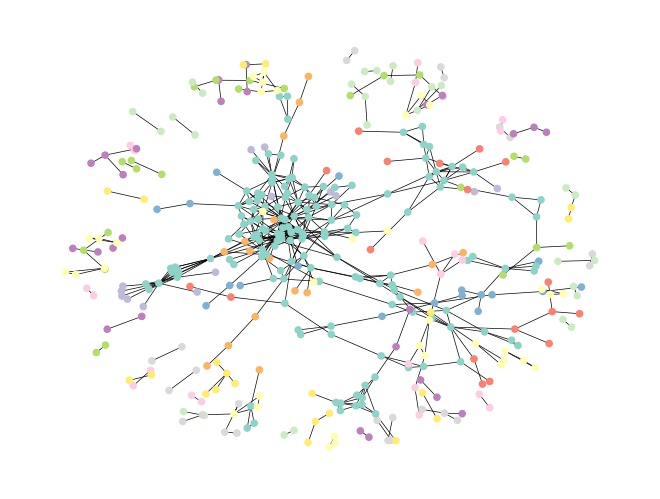

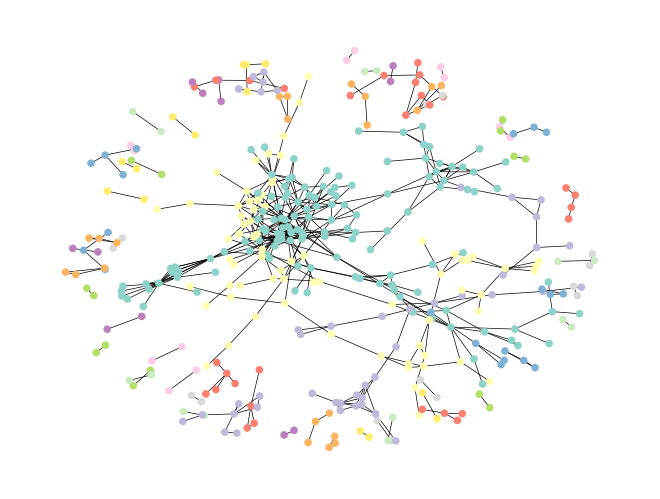

In [97]:
# Partition 1 plot
G = GroupsG
pos = nx.spring_layout(G, k = 0.12, seed= 43)
colors = [partition1[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, width = 0.5, node_size = 20, cmap=plt.cm.Set3)
plt.show()

# Partition 2 plot
pos = nx.spring_layout(G, k = 0.12, seed= 43)
colors = [partition2[n] for n in G.nodes()]
nx.draw(G, pos, node_color=colors, width = 0.5, node_size = 20, cmap=plt.cm.Set3)
plt.show()

To figure out which community partition is the best we compute the modularity of each partition.

In [98]:
label_to_nodes = defaultdict(set)
for node, label in partition1.items():
    label_to_nodes[label].add(node)

# Convert the values to a list of sets
communities1 = list(label_to_nodes.values())


label_to_nodes = defaultdict(set)
for node, label in partition2.items():
    label_to_nodes[label].add(node)

# Convert the values to a list of sets
communities2 = list(label_to_nodes.values())

modularity1 = nx.algorithms.community.modularity(GroupsG, communities1)
modularity2 = nx.algorithms.community.modularity(GroupsG, communities2)
print(f"modularity of partition 1: {round(modularity1,2)}")
print(f"modularity of partition 2: {round(modularity2,2)}")

modularity of partition 1: 0.54
modularity of partition 2: 0.79


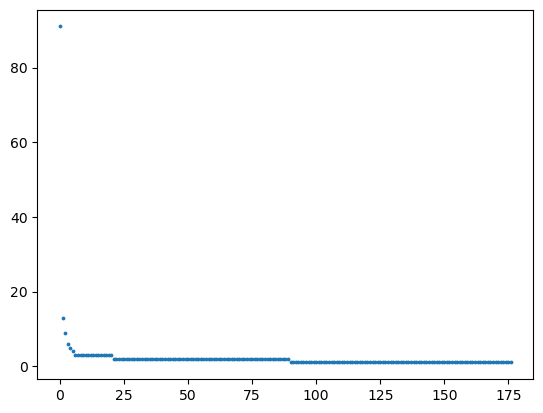

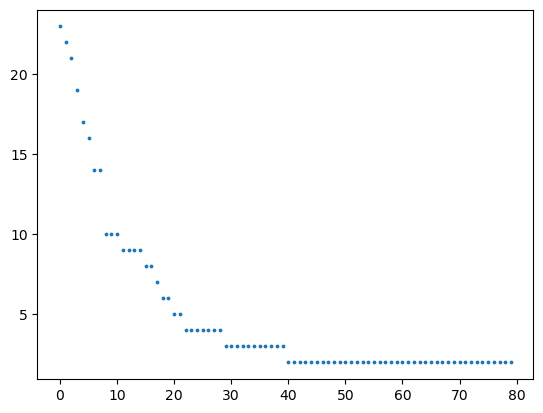

In [104]:
plt.scatter(list(range(len(Counter(partition1.values())))), [x[1] for x in sorted(Counter(partition1.values()).items(), key= lambda x: x[1], reverse=True)], s = 3)
plt.show();
plt.scatter(list(range(len(Counter(partition2.values())))), [x[1] for x in sorted(Counter(partition2.values()).items(), key= lambda x: x[1], reverse=True)], s = 3);

#### Text Analysis

With this partition of the network, we want to analyse the given communities. Here we have chosen to look at the introduction text of a groups Wikipedia page, which is around 5-10 lines of text. We have chosen not to include the entire article, as the length of articles may vary a lot based on the popularity of the group, whereas the introduction text is around the same length for all groups.

# Indsæt fetch af text  + Genre her

Now that we have got the text, we clean it by removing everything, except letters, and also making the text lowercase. 

In [107]:
def clean_text(text):
    if not isinstance(text, str):
        return {}
    clean_text = re.sub(r'<.*?>', '', text)
    wordlist = [re.sub(r"[^a-zA-ZæøåÆØÅ]+", '', word.lower()) for word in clean_text.split() if re.sub(r"[^a-zA-Z]+", '', word.lower())]
    return wordlist

In [108]:
df_groups = pd.read_csv("data/groups_wMembers_Text.csv")[["title", "intro_text"]]
df_groups["textlist"] = df_groups["intro_text"].apply(clean_text)

Next we assign each group in the dataframe to a community, given the louvain partition.

In [109]:
def group2community(group):
    try:
        return partition2[group]
    except:
        return None

df_groups["community"] = df_groups["title"].apply(group2community)
df_groups = df_groups.dropna(subset=['community'])
df_groups = df_groups.reset_index(drop=True)

We now construct a dataframe where each row corresponds to one community, the columns including the body of words used in the community and the genres for all groups in the community.

In [110]:
com_members = df_groups.groupby('community')['title'].apply(
    lambda x: [band for band in x])

To make the text ready for analysis, we first remove danish stopwords using the nltk library. This is done as stopwords are words that dont carry information, and thus is not interesting to analyse. Furthermore to ensure that only real words are part of the analysis, we load the danish dictionary and only consider words which appears here. For some reason single letters is a part of the dictionary, but as these (apart from i, ø and å) dont mean anything these are removed.

In [111]:
from nltk.corpus import stopwords
stop_words = stopwords.words('danish')

with open("data/da_DK.dic", encoding="utf-8") as f:
    danish_words = set()
    for line in f:
        word = line.strip().split("/")[0]
        danish_words.add(word.lower())

for letter in "abcdefghjklmnopqrstuvxyzæ":
    if letter in danish_words:
        danish_words.remove(letter)

We tried doing the analysis based on this preprocessing, but a problem appeared that often times the name of musicians popped up, as these will obviously be mentioned a lot of times in one article but not in another. Since we already have the names of members, this provides no additional information to the analysis. therefore we decided to remove all names of members and groups from the text.

In [112]:
member_names = list(pd.read_csv("data/musicians_wMembers.csv")["name"].apply(lambda x: str(x).split()))
member_names = [name.lower() for person in member_names for name in person]

group_names = list(df_groups["title"].apply(lambda x: x.split()))
group_names = [word.lower() for groupname in group_names for word in groupname]

In [113]:
def filter_text(word_lists, danish_words): #to only include words from danish dictionary, and not stop words
    all_words = chain.from_iterable(word_lists)
    return [word for word in all_words if (word in danish_words) and (word not in stop_words + member_names + group_names)]

com_words = df_groups.groupby('community')['textlist'].apply(
    lambda x: filter_text(x, danish_words))

With this a dataframe is constucted

In [114]:
communities = pd.DataFrame({
    'community': range(1, len(com_members) + 1),
    'groups': list(com_members),
    'com_words': list(com_words) 
    })

The genres are added to the dataframe, as well as a dictionary of the frequency of the genres in the community.

In [118]:
df_genres = pd.read_csv("data/groups_wMembers_Text_Genres.csv")[["title", "genres"]]
dict_genres = df_genres.set_index('title')['genres'].apply(lambda x: ast.literal_eval(x)).to_dict()
communities["genres"] = communities["groups"].apply(lambda x: [genre for group in x for genre in dict_genres[group]])

def freq(wordlist):
    word_counts = Counter(wordlist)
    total = sum(word_counts.values())
    word_freq = {word: round(count / total,3) for word, count in word_counts.items()}
    sorted_freq = dict(sorted(word_freq.items(), key=lambda item: item[1], reverse=True))
    return sorted_freq

communities["genrecount"] = communities["genres"].apply(freq)

For the text analysis we decided to do TF-IDF as well as a sentiment analysis. 

TF-IDF is a good way of identifiing which words are characteristic for a given community, and can be a way of understanding what defines the communities.

The sentiment analysis might say something about the succesfullness of the groups. If a group is succesful, it is likely that they will be described using more positive words. This is not sure though, so we will be careful not to make to strong conclutions based on this.

There is not a lot of resources for sentiment analysis in danish, but we found a dictionary, where every word had a score, 0 being neutral, positive numbers being positive words and vise versa. 

In [119]:
# Load the lexicon
lexicon = pd.read_csv("data/AFINN-da-32.txt", sep="\t", header=None, names=["word", "score"])

# Turn into dictionary for fast lookup
sentiment_dict = dict(zip(lexicon.word, lexicon.score))

#compute sentiment scores
communities["scores"] = communities["com_words"].apply(lambda words: sum(sentiment_dict.get(word, 0) for word in words)/len(words))

Below an IDF dictionary is created for all words in the corpus

In [120]:
all_words = []
for com in com_words:
    all_words.extend(com)
word_counts = Counter(all_words)
unique_words = list(word_counts.keys())

def IDF(words):
    N = len(com_words)
    DF_dict = {word: 0 for word in words}

    for com in com_words:
        com_set = set(com)
        for word in words: 
            if word in com_set:
                DF_dict[word] +=1

    IDF_dict = {word: float(np.log(N/DF_dict[word])) for word in words}    
    return IDF_dict

IDF_dict = IDF(unique_words)

Below the results are printed for the 5 biggest communities

In [124]:
sorted_communities = [x[0] for x in sorted(Counter(partition2.values()).items(), key= lambda x: x[1], reverse=True)]

for com in sorted_communities[:5]:
    words = communities["com_words"][com] # getting the wordlist for the given community
    TF = Counter(words) # creating dictionary of counts
    TF_IDF = {word: TF[word] * IDF_dict[word] for word in words}
    most_TFIDF_words = Counter(TF_IDF).most_common(20)
    dict_degree = dict(sorted([[band, degree] for band, degree in dict(GroupsG.degree()).items()], key=lambda x: int(x[1]), reverse=True))
    top_groups = sorted({group: dict_degree[group] for group in communities["groups"][com]}.items(), key = lambda x: x[1], reverse = True)
    print("--------------------------------")
    print(f"Community {com}")
    print(f"groups in community: {len(communities['groups'][com])}")
    print(f"top groups, by degree: {[x[0] for x in top_groups[:3]]}")
    print("top genres: " + ', '.join(f"{genre}: {int(score * 100)}%" for genre, score in list(communities['genrecount'][com].items())[:3]))
    print(f"sentiment score: {round(communities['scores'][com],3)}")
    print(f"Top TF-IDF words: {', '.join(np.asarray(most_TFIDF_words)[:,0])}")

--------------------------------
Community 0
groups in community: 24
top groups, by degree: ['Frede Fup', 'Lone Kellermann og Rockbandet', 'Delta Cross Band']
top genres: rock: 56%, pop: 23%, blues: 6%
sentiment score: 0.022
Top TF-IDF words: år, annmette, solgt, bestod, succes, kort, teatret, skrevet, kor, jubilæum, konstellation, glenn, resultat, ruin, amager, ryslinge, kro, silkeborg, kirkegård, inden
--------------------------------
Community 1
groups in community: 23
top groups, by degree: ['Odense Symfoniorkester', 'Det Kongelige Kapel', 'Esbjerg Ensemble']
top genres: classical: 45%, choral: 22%, opera: 13%
sentiment score: 0.058
Top TF-IDF words: chefdirigent, oprettet, musikkonservatorium, verdens, grundlagt, begivenhed, musik, fjerde, ca, ny, nordisk, kompositionsmusik, kunstfond, verden, giver, ældste, grammy, fokus, opera, kapelmester
--------------------------------
Community 2
groups in community: 23
top groups, by degree: ['Kansas City Stompers', 'Hos Anna', 'Danser med 

## Discussion

<span style="color:green"> Discussion. Think critically about your creation
- [ ] <span style="color:green"> What went well?
- [ ] <span style="color:green"> What is still missing? What could be improved? Why?
